# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---



---


![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### Steps 


* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

*  [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip). 

* [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip). 



In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [85]:
import numpy as np
from glob import glob


dog_files = np.array(glob("dogImages/*/*/*"))


print('There are %d total dog images.' % len(dog_files))

There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


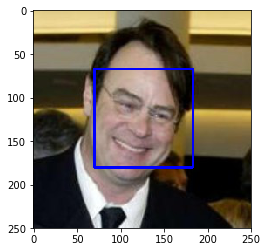

In [4]:
import numpy as np
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [87]:
import numpy as np
import cv2                
import matplotlib.pyplot as plt  

In [88]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [89]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [90]:
x=face_detector(dog_files[0]) #check 
print(x)

False


### Assessment of  the Human Face Detector





human count out of 100 is  98

dog count out of 100 is  17

In [12]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
ch=0
cd=0
for x in human_files_short:
    if(face_detector(x)== True):
        ch=ch+1
print( 'human count out of 100 is ',ch)

for x in dog_files_short:
    if(face_detector(x)== True):
        cd=cd+1
print('dog count out of 100 is ',cd)

human count out of 100 is  98
dog count out of 100 is  17


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [91]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

In [92]:
print(VGG16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [93]:
import torchvision
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    file=img_path
    file = Image.open(file).convert('RGB')
    
    ## Load and pre-process an image from the given img_path
    transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                         transforms.ToTensor(),
                                         torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])
    #img = transform(file).unsqueeze(0)
    t = transform(file)
    img = torch.unsqueeze(t, 0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    VGG16.eval()
    with torch.no_grad():
        out = VGG16(img.to(device))
        #print(out)
        ps = torch.exp(out)
        #print(ps)
        top_p, top_class = ps.topk(1, dim=1)
        index = top_class.item()  
        
    return index # predicted class index
    
    


In [94]:
VGG16_predict(dog_files[0])

252

### Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

 The `dog_detector` function below,  returns `True` if a dog is detected in an image (and `False` if not).

In [95]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    
    index = VGG16_predict(img_path)
    return True if index in range(151, 269) else False


###  Assess the Dog Detector





dog in human file out of 100 is  2

percentage =2%


dog in dog files count out of 100 is  98

percentage=98%

In [36]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
ch1=0
cd1=0
for x in human_files_short:
    if(dog_detector(x)== True):
        ch1=ch1+1
print( 'dog in human file out of 100 is ',ch1)

for x in dog_files_short:
    if(dog_detector(x)== True):
        cd1=cd1+1
print('dog in dog files count out of 100 is ',cd1)

dog in human file out of 100 is  2
dog in dog files count out of 100 is  98


###  trying Resnet 50 

In [34]:

RES50 = models.resnet50(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    RES50 = RES50.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 88949670.95it/s]


In [35]:
def RESNET50_predict(img_path):
    '''
    Use pre-trained RESNET-50 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to ResNet-50 model's prediction
    '''
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    file=img_path
    file = Image.open(file).convert('RGB')
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                         transforms.ToTensor(),
                                         torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])
    #img = transform(file).unsqueeze(0)
    t = transform(file)
    img = torch.unsqueeze(t, 0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    RES50.eval()
    with torch.no_grad():
        out = RES50(img.to(device))
        ps = torch.exp(out)
        top_p, top_class = ps.topk(1, dim=1)
        index = top_class.item()  
        
    return index # predicted class index

In [ ]:
def dog_detectorres(img_path):
    ## TODO: Complete the function.
    index = RESNET50_predict(img_path)
    return True if index in range(151, 269) else False

In [37]:
ch2=0
cd2=0
for x in human_files_short:
    if(dog_detector(x)== True):
        ch2=ch2+1
print( 'dog in human file out of 100 is ',ch2)

for x in dog_files_short:
    if(dog_detector(x)== True):
        cd2=cd2+1
print('dog in dog files count out of 100 is ',cd2)

dog in human file out of 100 is  0
dog in dog files count out of 100 is  100


#### WE see that here pratrained renet 50 has performed better than VGG16

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### Specify Data Loaders for the Dog Dataset


In [96]:
import os
from torchvision import datasets

train_dir = 'dogImages/train'
test_dir = 'dogImages/test'
valid_dir = 'dogImages/valid'



In [97]:

train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])


train_data = datasets.ImageFolder(train_dir , transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)


trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [98]:

print(f"training examples contain : {len(train_data)}")
print(f"validation examples contain : {len(valid_data)}")
print(f"testing examples contain : {len(test_data)}")

print('----in each batch we have----- ')
print(len(trainloader))
print(len(validloader))
print(len(testloader))

training examples contain : 6680
validation examples contain : 835
testing examples contain : 836
----in each batch we have----- 
105
14
14




I choose size as 224 * 224 for input tensor by resizing and cropping it using transform
- transforms.Resize(256)
- transforms.CenterCrop(224) 

Yes, data augmentations can help in increase the training examples on the fly during training and help to increase the performance of architechture due to randomly indtroduced variations of the sampled examples which i have implemented here using transforms
- transforms.RandomRotation(30)
- transforms.RandomResizedCrop(224)
- transforms.RandomHorizontalFlip()

### Model Architecture

Created a CNN to classify dog breed. 

Image shape : torch.Size([64, 3, 224, 224])
Label shape : torch.Size([64])


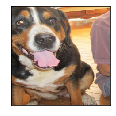

tensor(79)
080.Greater_swiss_mountain_dog


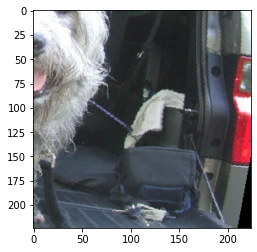

tensor(74)
075.Glen_of_imaal_terrier


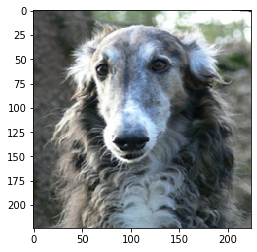

tensor(30)
031.Borzoi


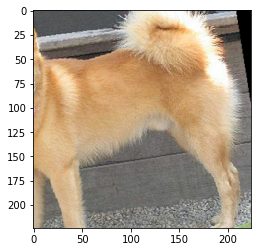

tensor(66)
067.Finnish_spitz


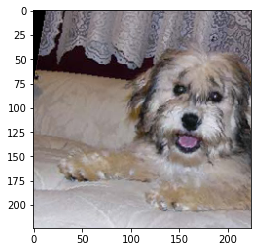

tensor(81)
082.Havanese


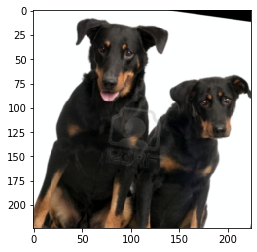

tensor(17)
018.Beauceron


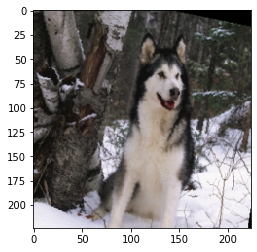

tensor(4)
005.Alaskan_malamute


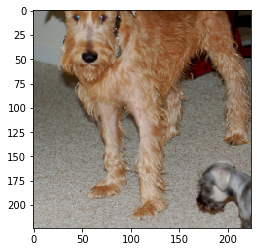

tensor(86)
087.Irish_terrier


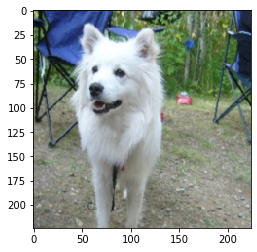

tensor(5)
006.American_eskimo_dog


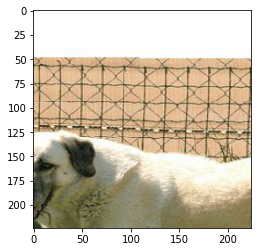

tensor(9)
010.Anatolian_shepherd_dog


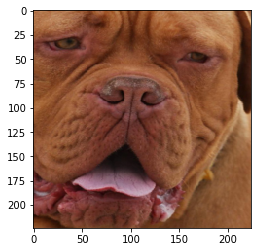

tensor(59)
060.Dogue_de_bordeaux


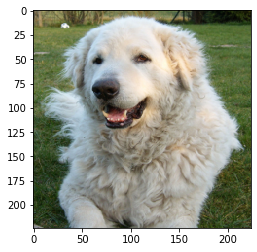

tensor(94)
095.Kuvasz


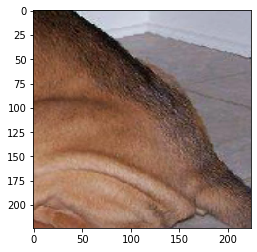

tensor(26)
027.Bloodhound


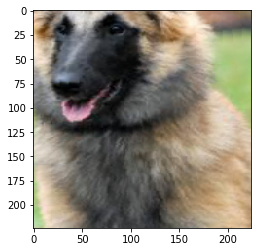

tensor(21)
022.Belgian_tervuren


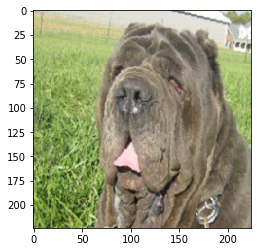

tensor(104)
105.Neapolitan_mastiff


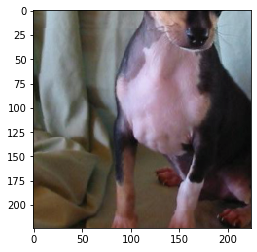

tensor(47)
048.Chihuahua


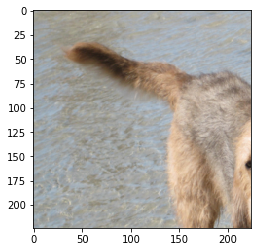

tensor(113)
114.Otterhound


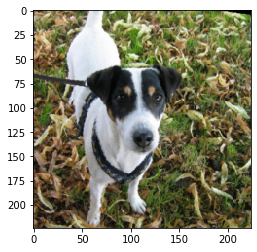

tensor(115)
116.Parson_russell_terrier


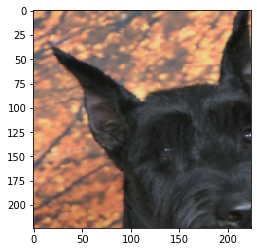

tensor(73)
074.Giant_schnauzer


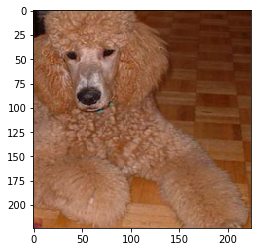

tensor(123)
124.Poodle


In [99]:
import matplotlib.pyplot as plt
%matplotlib inline

images, labels = next(iter(trainloader))

# Checking shape of image
print(f"Image shape : {images.shape}")
print(f"Label shape : {labels.shape}")
 
class_names = train_data.classes

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(class_names[(labels[idx]).item()])
    print(labels[idx])
    print(class_names[(labels[idx]).item()])

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [101]:
print(class_names[0])

001.Affenpinscher


In [102]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        #conv seess 224*224*3 and we have 133 classes at end
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 28 * 28 -> 500)
        
        self.fc1 = nn.Linear(64 * 28 * 28, 500)
        # linear layer (500 -> 133)
        self.fc2 = nn.Linear(500, 133)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # flatten image input
        x = x.view(-1, 64 * 28 * 28)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu((self.fc1(x)))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x


# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [103]:
model_scratch

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.5)
)

__Explantion of architecture:__


First i wanted CNN layers and so used Conv2d for setting three layers of conv layers namely
(conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
since the images have 3 color channels, so in_channel of first conv layer namely conv1 will be "3" and then other channels and filter size are set by choosing arbitarily because they are hyperparameters and conv1 in_channel was data dependent parameter and so is last layer fc2 out_features as "133" due to 133 categories of dog breeds we want to classify.

Now, in_features of fc1 also is data dependent parameter and hence choosen as depth set by out_channels of conv3 and height * width set by pooling.

Pooling of window size 2 is used here to downsample the parameters otherwise training the network with much many parameters would require high computational complexity. So, after every convolutional layer and pooling , the dimensions height \ width is reduced by factor of 1/2. Max Pooling is used here so that maximum number out of all calculated numbers in feature maps is chosen so as to select relevant features only.

(pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Dropout is used here to reduce overfitting as i saw the network tried to overfit the dataset very soon.

(dropout): Dropout(p=0.5, inplace=False)

###  Loss Function and Optimizer



In [73]:
import torch.optim as optim

criterion_scratch= nn.CrossEntropyLoss()

optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.002, momentum=0.9)

In [46]:
loaders_scratch = {
    'train': trainloader,
    'valid': validloader,
    'test': testloader
}

### Train and Validate the Model



In [78]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            ## find the loss and update the model parameters accordingly
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            #forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss,valid_loss))
        
       
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
            print(" ")
            torch.save(model.state_dict(),save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model


# train the model
model_scratch = train(50, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.886454 	Validation Loss: 4.869884
Validation loss decreased (inf --> 4.869884).  Saving model ...
 
Epoch: 2 	Training Loss: 4.870710 	Validation Loss: 4.846887
Validation loss decreased (4.869884 --> 4.846887).  Saving model ...
 
Epoch: 3 	Training Loss: 4.845342 	Validation Loss: 4.790235
Validation loss decreased (4.846887 --> 4.790235).  Saving model ...
 
Epoch: 4 	Training Loss: 4.774395 	Validation Loss: 4.682907
Validation loss decreased (4.790235 --> 4.682907).  Saving model ...
 
Epoch: 5 	Training Loss: 4.693630 	Validation Loss: 4.579301
Validation loss decreased (4.682907 --> 4.579301).  Saving model ...
 
Epoch: 6 	Training Loss: 4.631251 	Validation Loss: 4.475163
Validation loss decreased (4.579301 --> 4.475163).  Saving model ...
 
Epoch: 7 	Training Loss: 4.592149 	Validation Loss: 4.390450
Validation loss decreased (4.475163 --> 4.390450).  Saving model ...
 
Epoch: 8 	Training Loss: 4.559964 	Validation Loss: 4.383087
Validation loss decr

In [12]:
x=torch.load('model_scratch.pt')

In [13]:
print(x)

OrderedDict([('conv1.weight', tensor([[[[ 4.6539e-02,  1.5646e-01,  2.5044e-01],
          [-1.8402e-01, -9.3886e-02,  1.5781e-01],
          [-1.3089e-02, -9.0084e-02,  1.7933e-01]],

         [[-2.3240e-01, -2.8065e-01, -1.2516e-01],
          [-2.5198e-01, -2.2133e-01, -8.2447e-02],
          [-2.9724e-01,  5.8626e-02,  1.8093e-01]],

         [[ 1.7056e-01, -3.9326e-02, -3.4010e-02],
          [-1.1556e-02,  8.9124e-02,  2.7590e-01],
          [ 4.5490e-03,  2.1980e-01, -4.4538e-02]]],


        [[[-1.0153e-01,  1.3723e-01,  7.8728e-02],
          [-2.3747e-01,  1.2231e-01,  2.4294e-01],
          [-1.7867e-01, -1.2557e-01,  2.6417e-01]],

         [[ 1.7394e-02, -1.2925e-01, -1.2936e-01],
          [ 9.5476e-02,  5.6633e-02,  2.9000e-01],
          [ 6.2306e-02,  1.9758e-01,  3.2977e-01]],

         [[ 1.1843e-02, -2.1953e-01, -4.9828e-02],
          [-1.8533e-01,  1.3097e-02, -1.0208e-01],
          [-2.0367e-01, -3.2763e-02,  4.1212e-03]]],


        [[[-1.7413e-01,  2.9854e-02,

### Test the Model


In [79]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.705375


Test Accuracy: 13% (117/836)


---
<a id='step4'></a>
## Step 4:CNN to Classify Dog Breeds (using Transfer Learning)



In [104]:

loaders_transfer = {
    'train': trainloader,
    'valid': validloader,
    'test': testloader
}


### As in dog detetction with fully pretrained model ,resnet 50 performed better than vgg , we'll be using RESNET 50

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [105]:
# Load the pretrained model from pytorch
res50 = models.resnet50(pretrained=True)


In [106]:

# print out the model structure
print(res50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [107]:
print(res50.fc.out_features)

1000


In [108]:
for name,child in res50.named_children():
    print(name)
    print('**',child)
    print('---')

conv1
** Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
---
bn1
** BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
---
relu
** ReLU(inplace)
---
maxpool
** MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
---
layer1
** Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): Batch

In [109]:
import torchvision.models as models
import torch.nn as nn
model_transfer=res50

for name,child in model_transfer.named_children():
    if name in ['layer4','fc']:
        print(name + 'is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name + 'is frozen')
        for param in child.parameters():
            param.requires_grad = False

model_transfer.fc = nn.Sequential(
               nn.Linear(2048, 516),
               nn.ReLU(inplace=True),
               nn.Linear(516, 133))

if use_cuda:
    model_transfer = model_transfer.cuda()

conv1is frozen
bn1is frozen
reluis frozen
maxpoolis frozen
layer1is frozen
layer2is frozen
layer3is frozen
layer4is unfrozen
avgpoolis frozen
fcis unfrozen


In [110]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F


1. Chose resnet50 beacuse in dog face detetction with all param freezed , it performed better and also
     - light weight model
     - higher accuracy

Residual networks is based on theory that as we go deeper, we should make sure not to degrade accuracy and so, Keep learning the residuals to match the predicted with the actual and this is acheived by mapping the identity function.

This architechture contains 
- (conv1) as first convolutional layer containing in channels as 3 which is due to RGB input tensor 
- (bn1) as batch normalization layer
- followed by ReLU and MaxPooling 
- then it contains 4 main layers named layer1, layer2, layer3 and layer4 which contains further sub layers of convolution 
- followed by batchnorm 
- followed by relu 
- followed by maxpooling 
- and then finally fc.

ReLU activation is used as it's the most proven activation function for classification problems as it introduces good and right amount of non linearity with less chances of vanishing gradient problem !
Batch normalization helped in making the network more stable and learning faster thereby faster convergence.
Maxpooling helped in downsampling high number of parameters created by producing higher dimensional feature maps after convolution operation and thus selecting only relevant features from the high dimensioned feature matrix.
Then i replaced last layer of this architechture by fully connected layer containing two sub linear layers as follows : Linear(in_features=2048, out_features=512) Linear(in_features=512, out_features=133) with ReLU activations between the linears.
Now, the important thing is about unfrozing layers, so i choose to first only train layer4 and fc and then i unfroze one more layer layer3 which increased the accuracy and decreased the validation losses.


In [101]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer =  optim.SGD(filter(lambda p:p.requires_grad,model_transfer.parameters()), lr=0.002, momentum=0.9)
## need to pass only those param that are unfrrozen!!

### Train and Validate the Model



In [102]:
# train the model
n_epochs=50
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')



Epoch: 1 	Training Loss: 4.722241 	Validation Loss: 4.260810
Validation loss decreased (inf --> 4.260810).  Saving model ...
 
Epoch: 2 	Training Loss: 3.891512 	Validation Loss: 2.719768
Validation loss decreased (4.260810 --> 2.719768).  Saving model ...
 
Epoch: 3 	Training Loss: 2.648591 	Validation Loss: 1.566293
Validation loss decreased (2.719768 --> 1.566293).  Saving model ...
 
Epoch: 4 	Training Loss: 1.821002 	Validation Loss: 1.014901
Validation loss decreased (1.566293 --> 1.014901).  Saving model ...
 
Epoch: 5 	Training Loss: 1.387854 	Validation Loss: 0.795051
Validation loss decreased (1.014901 --> 0.795051).  Saving model ...
 
Epoch: 6 	Training Loss: 1.167945 	Validation Loss: 0.748533
Validation loss decreased (0.795051 --> 0.748533).  Saving model ...
 
Epoch: 7 	Training Loss: 0.997539 	Validation Loss: 0.564847
Validation loss decreased (0.748533 --> 0.564847).  Saving model ...
 
Epoch: 8 	Training Loss: 0.923837 	Validation Loss: 0.496929
Validation loss decr

In [111]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [112]:
y=torch.load('model_transfer.pt')

In [113]:
print(y)

OrderedDict([('conv1.weight', tensor([[[[ 1.3335e-02,  1.4664e-02, -1.5351e-02,  ..., -4.0896e-02,
           -4.3034e-02, -7.0755e-02],
          [ 4.1205e-03,  5.8477e-03,  1.4948e-02,  ...,  2.2060e-03,
           -2.0912e-02, -3.8517e-02],
          [ 2.2331e-02,  2.3595e-02,  1.6120e-02,  ...,  1.0281e-01,
            6.2641e-02,  5.1977e-02],
          ...,
          [-9.0349e-04,  2.7767e-02, -1.0105e-02,  ..., -1.2722e-01,
           -7.6604e-02,  7.8453e-03],
          [ 3.5894e-03,  4.8006e-02,  6.2051e-02,  ...,  2.4267e-02,
           -3.3662e-02, -1.5709e-02],
          [-8.0029e-02, -3.2238e-02, -1.7808e-02,  ...,  3.5359e-02,
            2.2439e-02,  1.7077e-03]],

         [[-1.8452e-02,  1.1415e-02,  2.3850e-02,  ...,  5.3736e-02,
            4.4022e-02, -9.4675e-03],
          [-7.7273e-03,  1.8890e-02,  6.7981e-02,  ...,  1.5956e-01,
            1.4606e-01,  1.1999e-01],
          [-4.6013e-02, -7.6075e-02, -8.9648e-02,  ...,  1.2108e-01,
            1.6705e-01,  1.7

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [105]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.343228


Test Accuracy: 89% (747/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [114]:

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_data.classes]

print(class_names[0])

Affenpinscher


In [125]:
def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
    file = img_path
    file = Image.open(file).convert('RGB')
    img = transform(file).unsqueeze(0)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model_transfer.eval()
    
    with torch.no_grad():
        
        out = model_transfer(img.to(device))
        ps = torch.exp(out)
        top_p, top_class = ps.topk(1, dim=1)
        index = top_class.item()
    return class_names[index]

In [126]:
predict_breed_transfer(dog_files[100])

'Basenji'

In [128]:
import matplotlib.pyplot as plt
import matplotlib
def display_breed(file):
    file = Image.open(file).convert('RGB')
    plt.imshow(file)
    matplotlib.pyplot.text(5, -20, "HEllO, Lets Detect the BREED !",
    color='black', fontsize=15)
    plt.show()

In [129]:
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if (dog_detector(img_path)):
        print("Dog Detected!")
        breed_name = predict_breed_transfer(img_path)
        display_breed(img_path)
        print("Predicted breed is :", breed_name)
    elif (face_detector(img_path)):
        print("HUMAN Detected!")
        breed_name_human = predict_breed_transfer(img_path)  
        display_breed(img_path)
        print("Predicted closest breed is:", breed_name_human)
    else:
        print("Neither a Dog nor a Human :( :( !")    


Dog Detected!


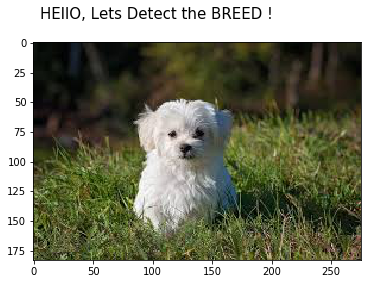

Predicted breed is : Maltese


In [130]:
run_app('1.jpeg')

Dog Detected!


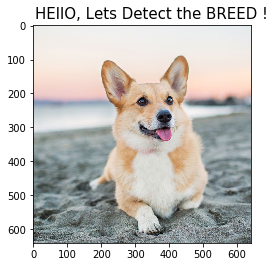

Predicted breed is : Pembroke welsh corgi


In [131]:
run_app('2.jpg')

Dog Detected!


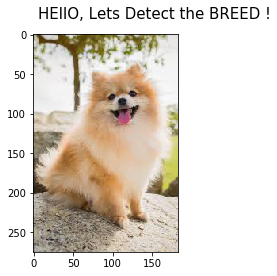

Predicted breed is : Pomeranian


In [132]:
run_app('3.jpeg')

HUMAN Detected!


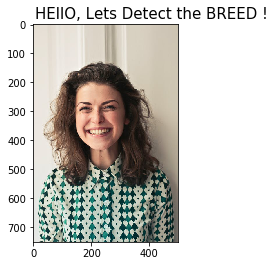

Predicted closest breed is: Havanese


In [133]:
run_app('4.jpeg')

HUMAN Detected!


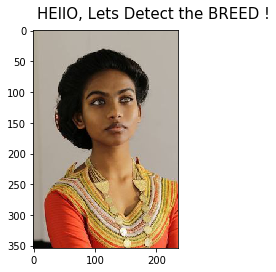

Predicted closest breed is: Basenji


In [135]:
run_app('5.jpg')

In [136]:
run_app('6.jpeg')

Neither a Dog nor a Human :( :( !


HUMAN Detected!


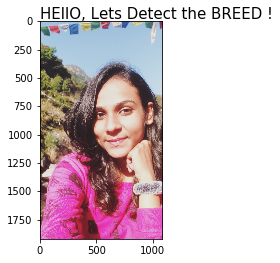

Predicted closest breed is: Havanese


In [140]:
run_app('me2.jpg')